<a href="https://colab.research.google.com/github/d-maniatakos/vaccine-sentiment-classifier/blob/master/vaccine_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Vaccine Sentiment Classifier using Softmax Regression**

---

Διονύσιος Μανιατάκος (Α.Μ: 1115201800104)

## **Modules Import**

In [76]:
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import matplotlib.pyplot as plt
import seaborn as sns

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Data Import**

In [77]:
# read datasets and ignore the first (index) column
train_data =  pd.read_csv('vaccine_train_set.csv').iloc[:, 1:]
validation_data = pd.read_csv('vaccine_validation_set.csv').iloc[:, 1:]    # <--- replace with test set path

train_data.head()

,tweet,label
0,Sip N Shop Come thru right now #Marjais #Popul...,0
1,I don't know about you but My family and I wil...,1
2,@MSignorile Immunizations should be mandatory....,2
3,President Obama spoke in favor of vaccination ...,0
4,"""@myfoxla: Arizona monitoring hundreds for mea...",0


## **Data Exploration**

### **Check for Null Values**

In [78]:
train_data.isnull().sum()

tweet    0
label    0
dtype: int64

There are no null values neither in tweet column nor in the label column.

### **Number of Neutral/Positive/Negative Tweets**

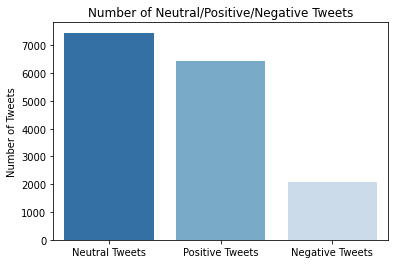

In [79]:
sns.barplot(x=['Neutral Tweets','Positive Tweets','Negative Tweets'], \
y=train_data['label'].value_counts(), palette='Blues_r').set\
(title='Number of Neutral/Positive/Negative Tweets', ylabel='Number of Tweets')
plt.show()

It's clear that most tweets in the training dataset express a neutral opinion on vaccines, a little less tweets express a positive opinion and the least tweets express a negative one. There's certainly an imbalance we should consider.

### **Number of N-Grams in Neutral/Negative/Positive Tweets**

In [80]:
def most_used_ngrams(corpus, max_features=15, ngrams=(2, 3), title=''):
  plt.figure(figsize=(min(max_features, 30),3), dpi=200)
  plt.title(title)
  plt.xticks(rotation=45)
  vectorizer = CountVectorizer(ngram_range=ngrams,  max_features=max_features, stop_words='english')
  ngrams = vectorizer.fit_transform(corpus)
  count_sum = ngrams.toarray().sum(axis=0)

  ngram_series = pd.Series(data=count_sum, index=vectorizer.get_feature_names_out()).sort_values(ascending=False)

  sns.barplot(x=ngram_series.index, y=ngram_series.values, palette='Blues_r')


neutral_tweets = train_data[train_data.label == 0]['tweet'].values
negative_tweets = train_data[train_data.label == 1]['tweet'].values
positive_tweets = train_data[train_data.label == 2]['tweet'].values

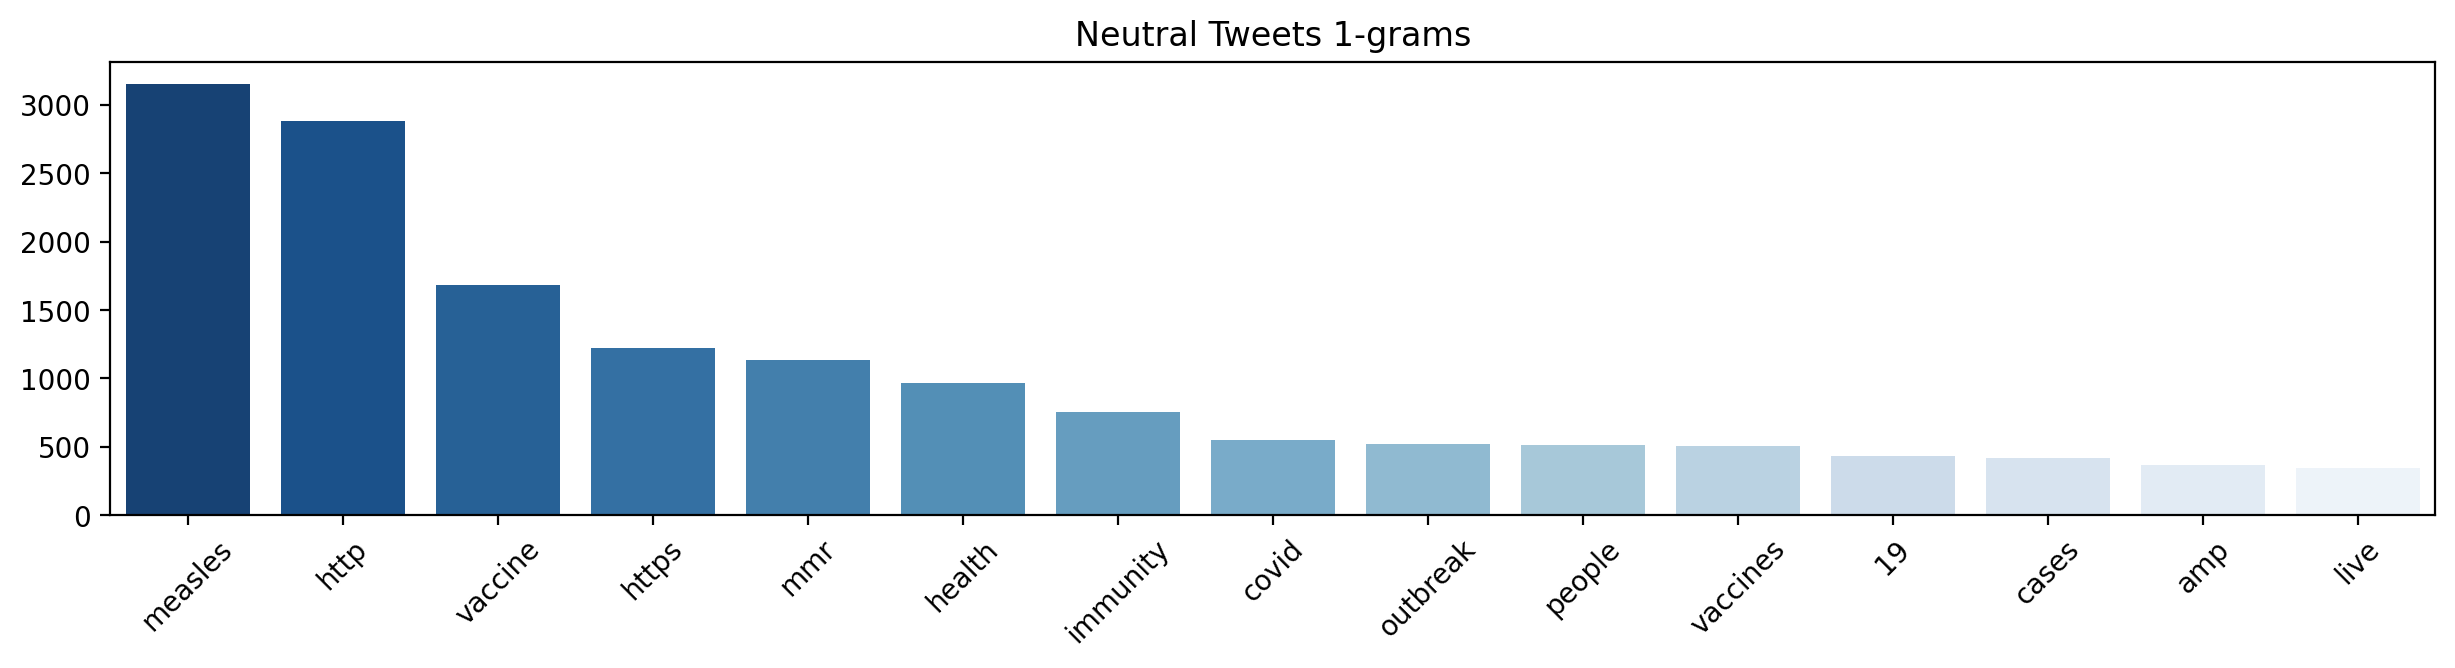

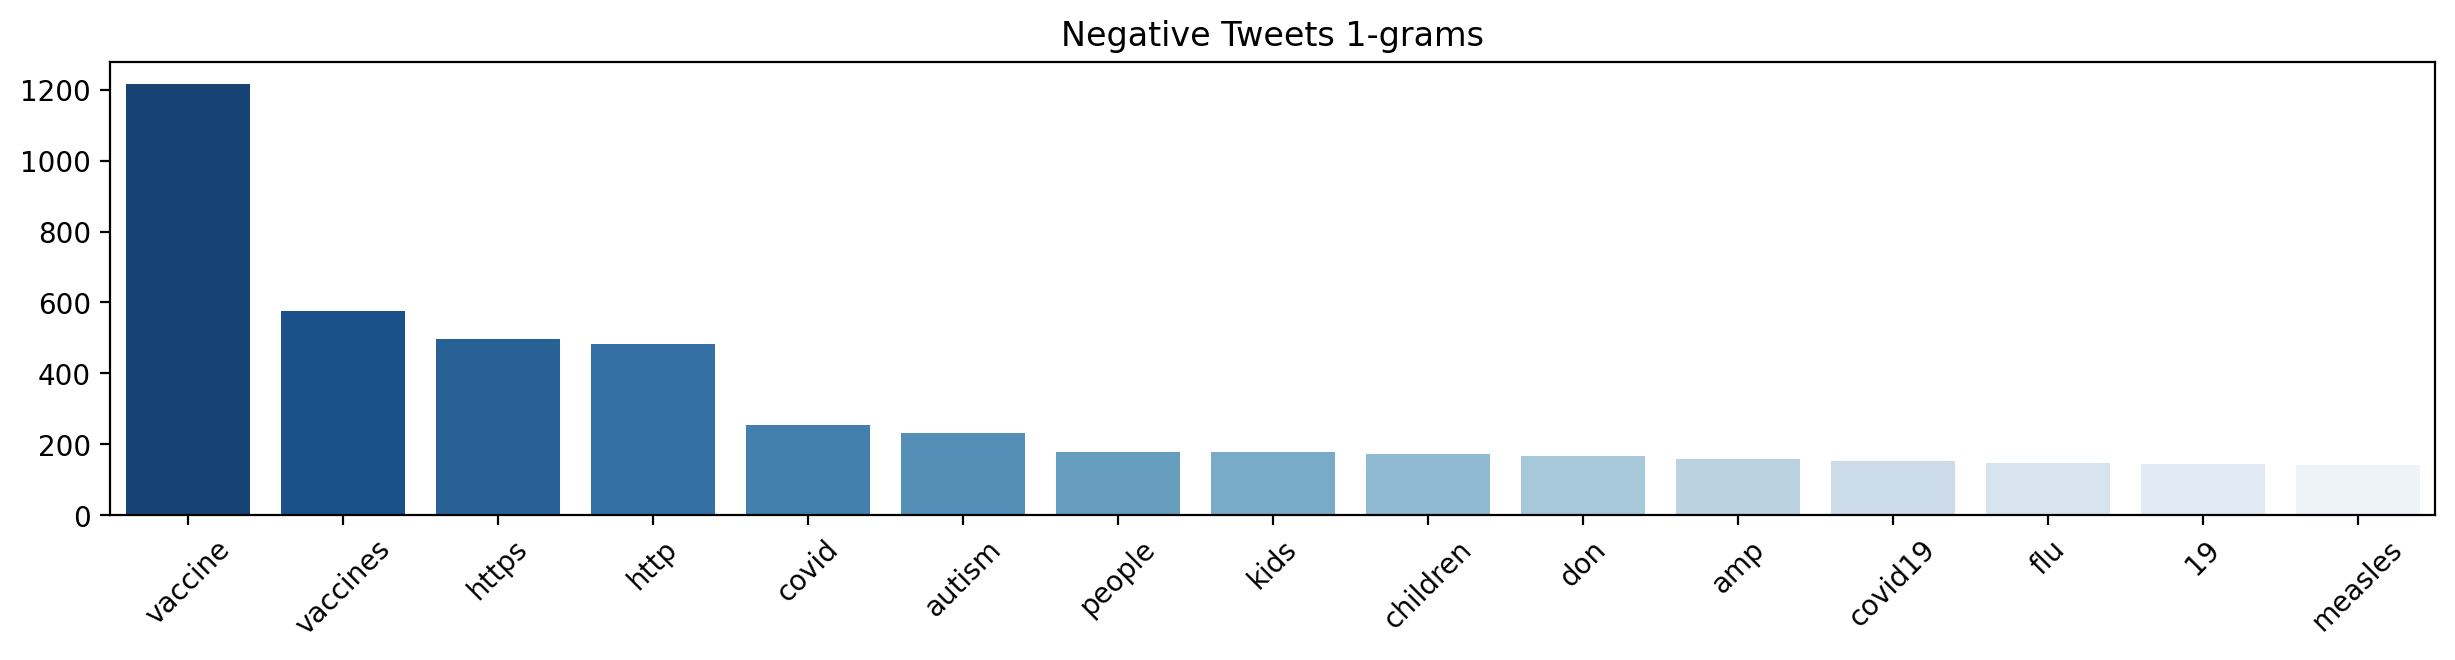

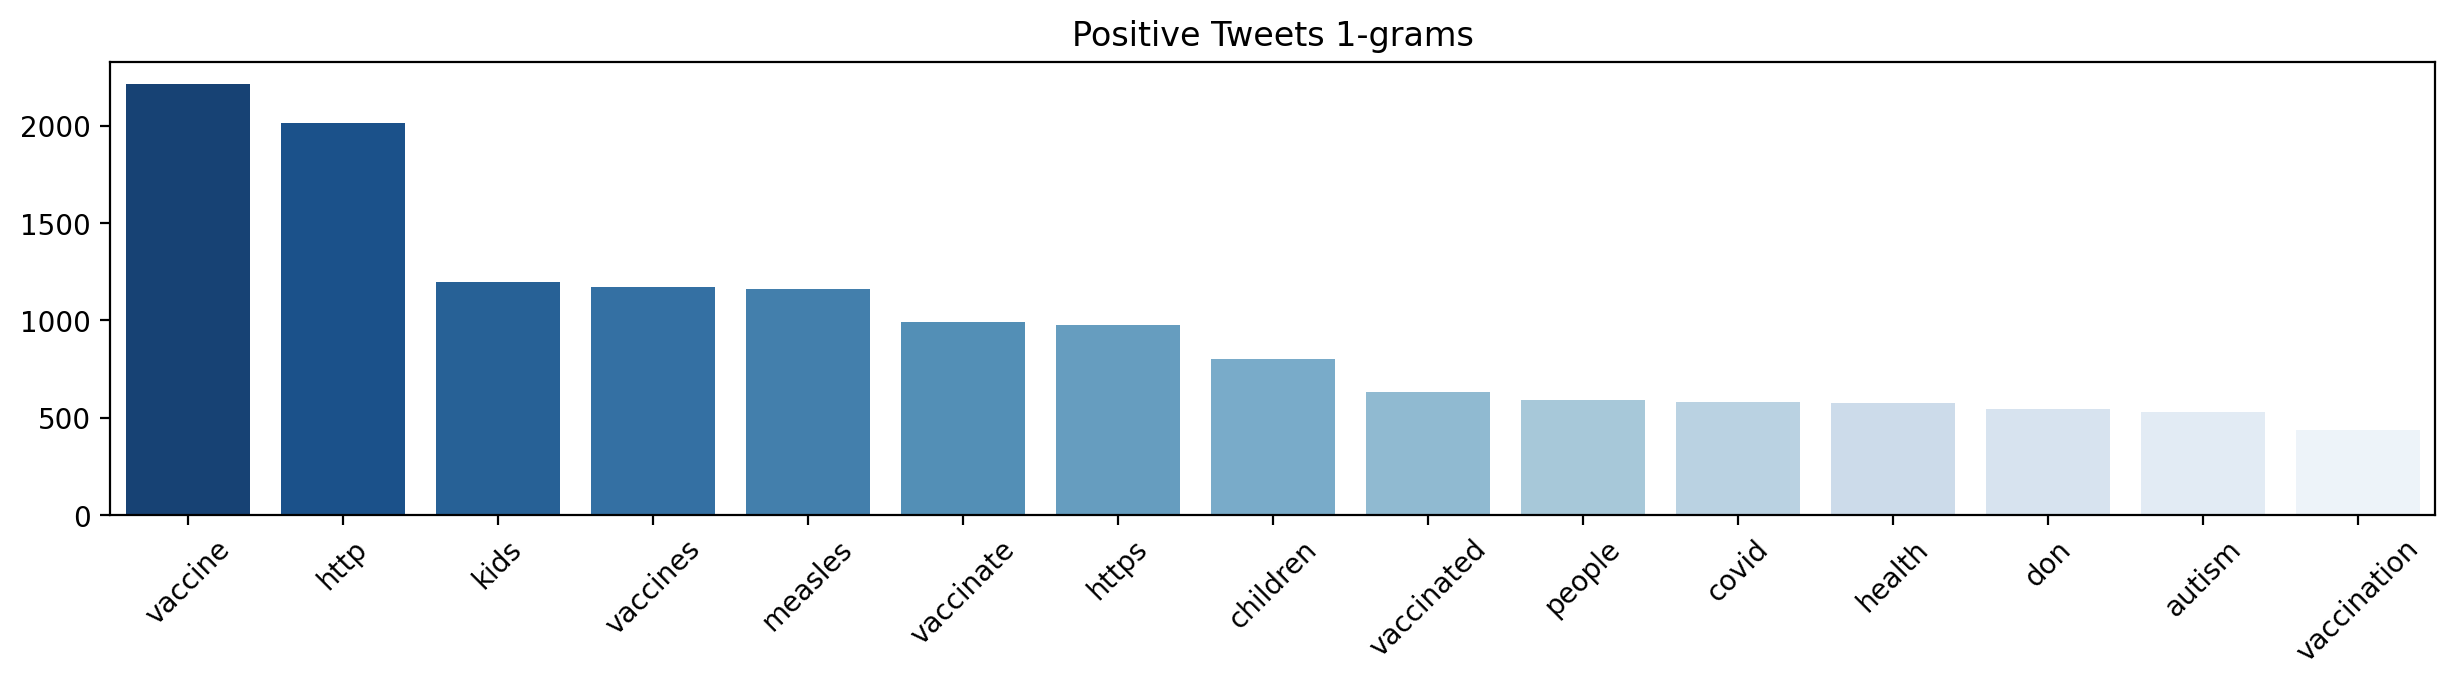

In [81]:
most_used_ngrams(neutral_tweets, title='Neutral Tweets 1-grams', ngrams=(1, 1))
most_used_ngrams(negative_tweets, title='Negative Tweets 1-grams', ngrams=(1, 1))
most_used_ngrams(positive_tweets, title='Positive Tweets 1-grams', ngrams=(1, 1))

All categories of tweets share same words more or less, making it hard to tell them apart just by 1-grams. Let's try bigrams!

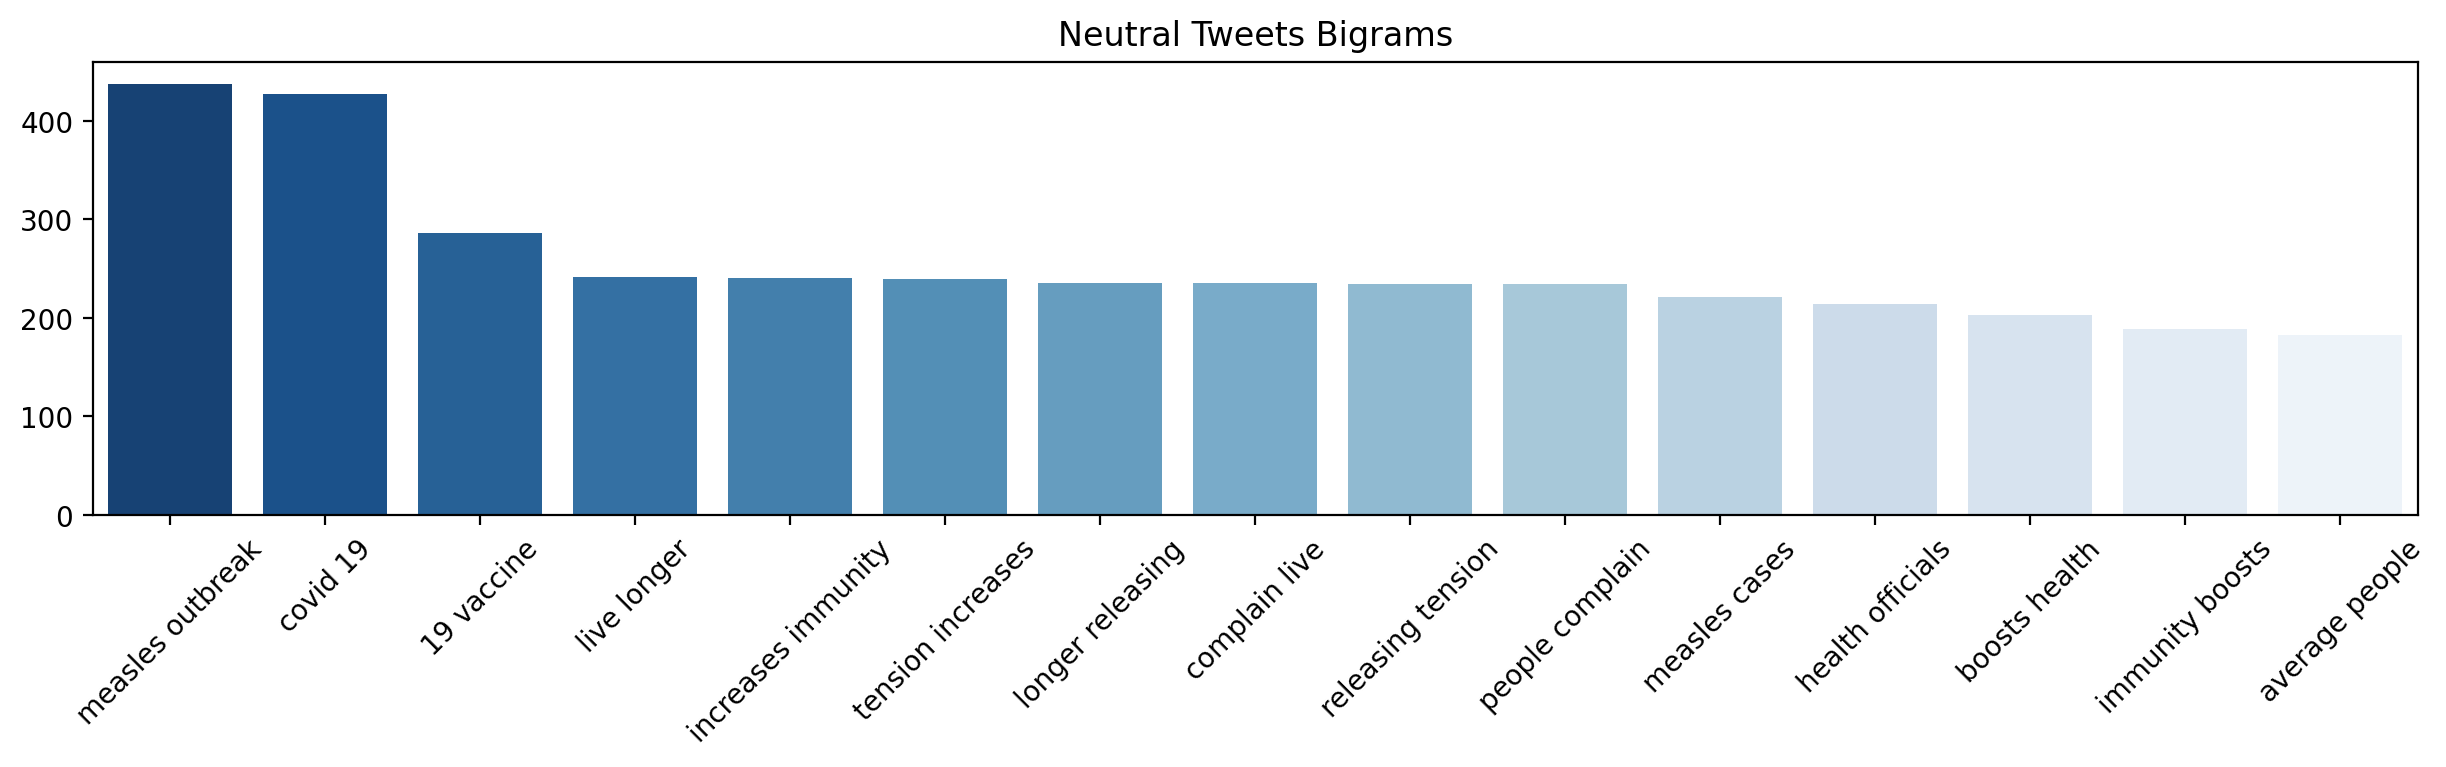

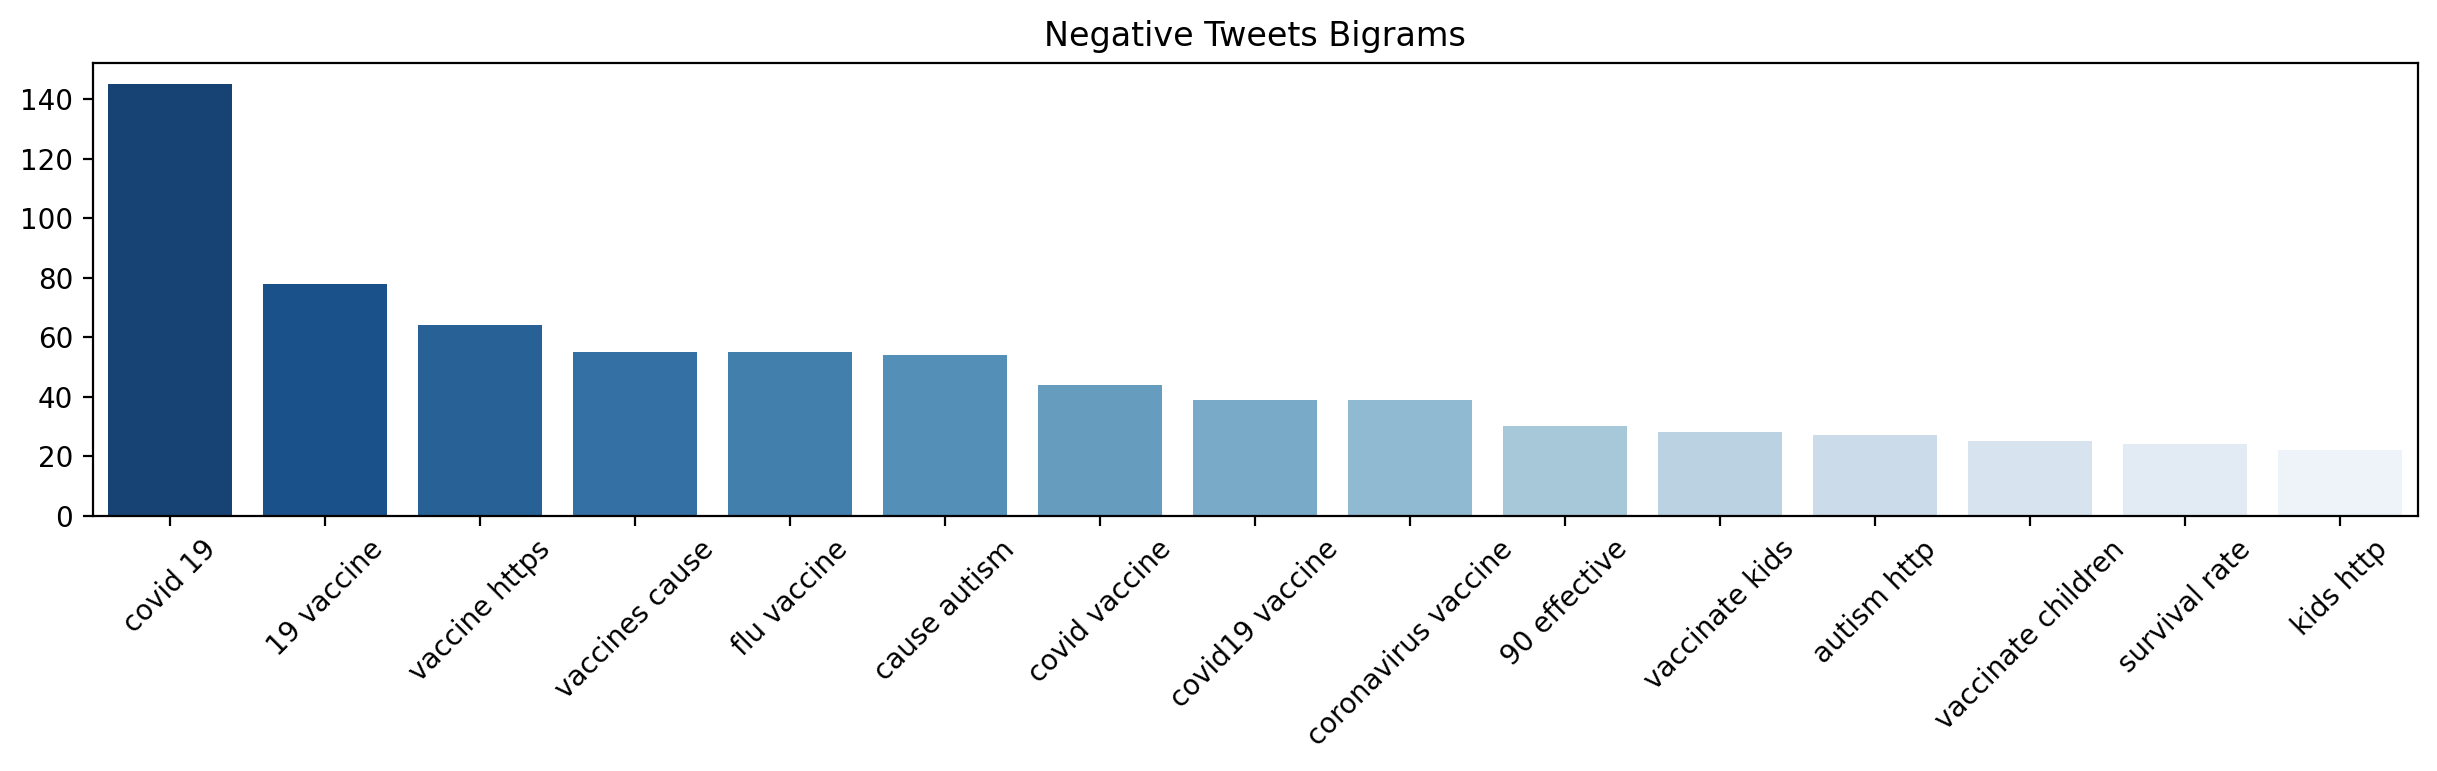

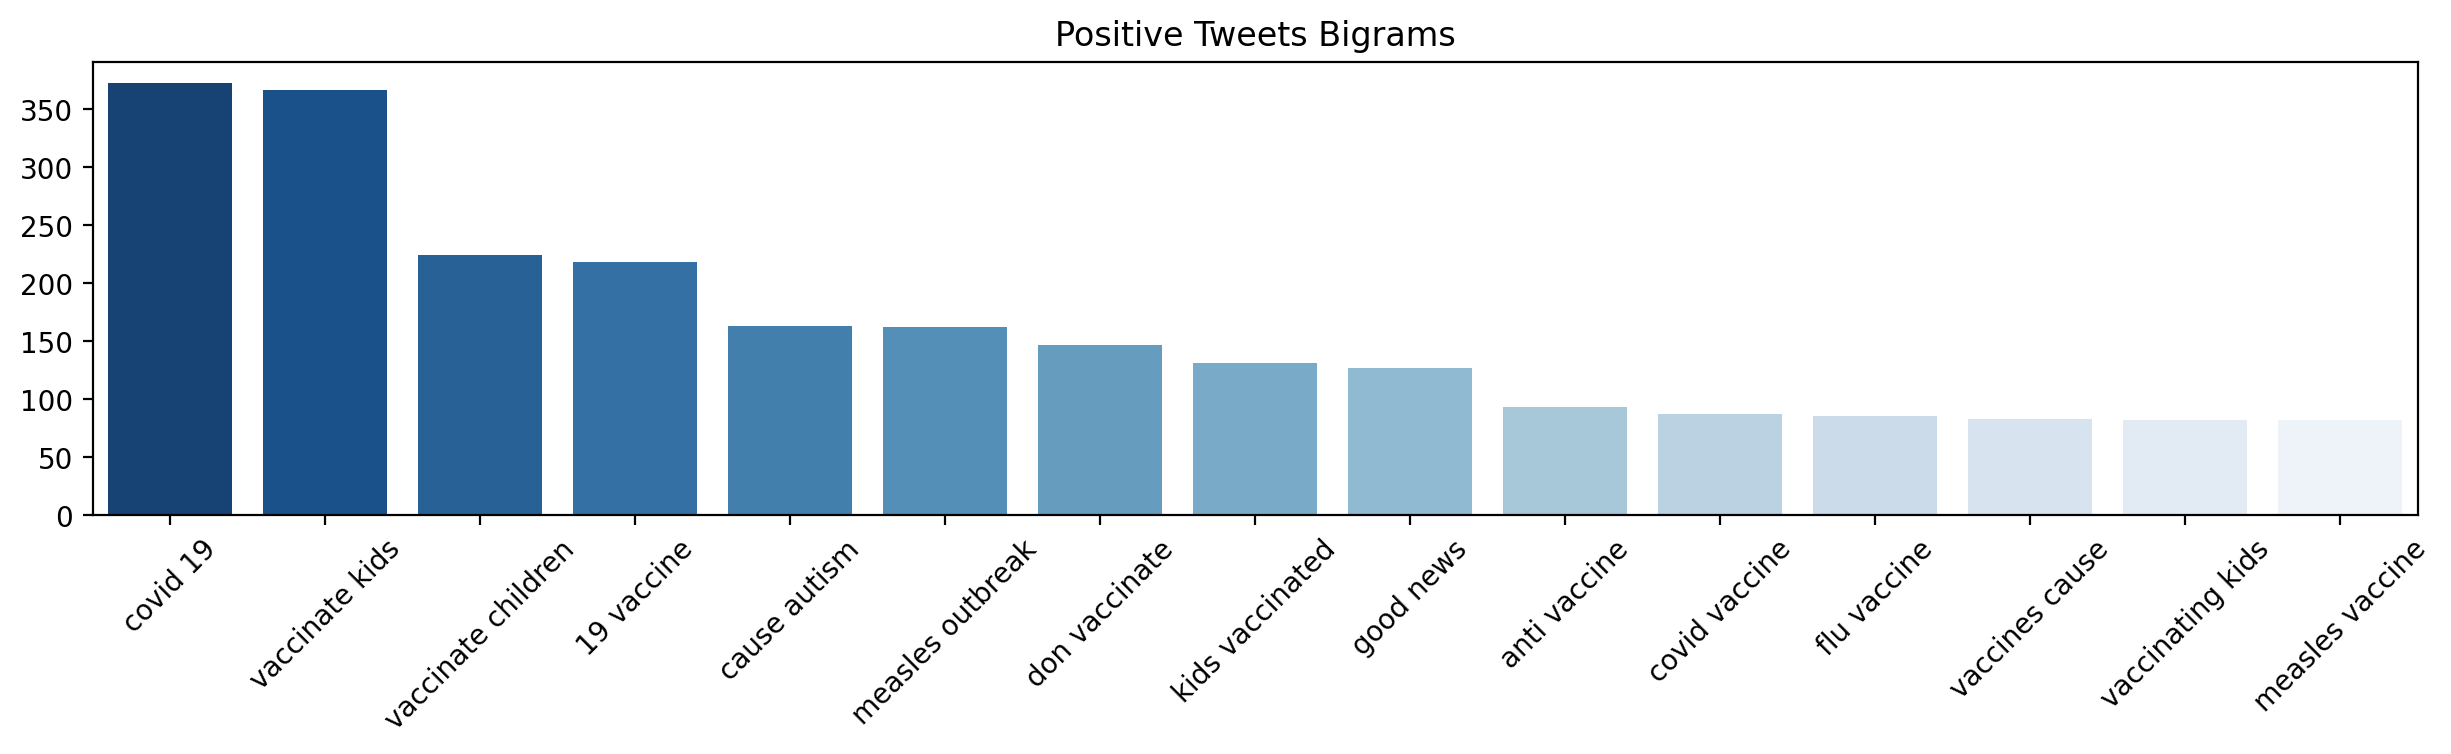

In [82]:
most_used_ngrams(neutral_tweets, title='Neutral Tweets Bigrams', ngrams=(2, 2))
most_used_ngrams(negative_tweets, title='Negative Tweets Bigrams', ngrams=(2, 2))
most_used_ngrams(positive_tweets, title='Positive Tweets Bigrams', ngrams=(2, 2))

While tweets from all three classes share many bigrams/phrases, it's clear that the neutral tweets have a more even distribution of bigrams. Negative tweets tend to use a lot of phrases mentioning autism (possible as an hypothetical side effect of vaccines). Such phrases are also used in positive tweets too. Let's see why this happens...

In [83]:
# print positive tweets which contain phrase "cause autism"
for tweet in positive_tweets.tolist():
  if 'cause autism' in tweet:
    print(tweet)
    

"But I also believe vaccines cause autism and have probably caused the deaths of dozens of children by spreading it" http://t.co/YflmFFoJuY
@AC360 and if people think vaccinations can cause autism would they rather have an autistic child or a dead child?
“@Gen_Ironicus: Dr. Oz is on tv spotlighting claims that vaccines cause autism. Reminder that everyone named Oz is a fraud.” @ozkangaroo D:&gt;
If vaccines don't cause autism, what's stopping you from faking autism and winning millions in vaccine court like others? y r u still poor?
People say that vaccines cause autism because autism has increased along with our use of vaccines. THAT DOESNT MEAN ANYTHING.
“@simonsmart23: @BarrowMillHouse @RobSchneider  not vaccinated my kids" not your fault vaccines do not cause autism http://t.co/T2evhWZJ9c
@lorabruncke @ScienceBasedRD @graceonline @MicheleRSimon lemme guess, vaccines cause autism and chemtrails make us sick, too?
Vaccines don't cause autism, #2048 does.
it was disproven DECADES ago 

It's clear that these tweets are indeed by pro-vaccinists who try to debunk arguments against vaccines, made by anti-vaccinists. This may make classification a lot harder.

### **Median Length of Neutral/Negative/Positive**

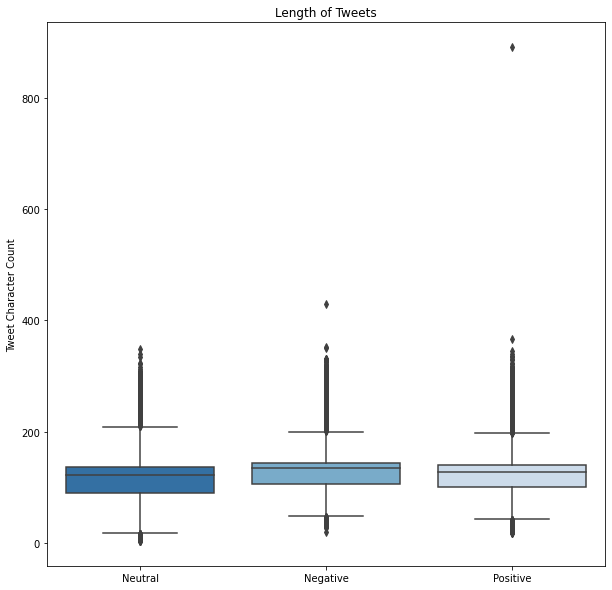

In [84]:
train_data_copy = train_data.copy()
train_data_copy['Tweet Character Count'] = train_data_copy['tweet'].str.len()
train_data_copy['label'] = train_data_copy['label'].map({0:'Neutral', 1:'Negative', 2:'Positive'})

plt.figure(figsize=(10, 10))
sns.boxplot(x="label", y="Tweet Character Count", data=train_data_copy, palette='Blues_r').set(title='Length of Tweets')
plt.xlabel('')
plt.show()

The negative tweets tend to be slightly longer while neutral tweets tend to be slightly shorter, but the difference is not that big to justify using it as a seperate feature in our model.

## **Pre-processing & Vectorization**

In [85]:
# preprocess tweets texts before vectorization
def preprocess(text):
  text = text.lower()
  unwanted_chars = ['@', '#', '!', '(', ')', '*', ':', ',']

  for char in unwanted_chars:
    text = text.replace(char, '')
  lemmatizer = WordNetLemmatizer()

  lemmatized_text = ''
  for word in text.split():
    lemmatized_text += lemmatizer.lemmatize(word) + ' '
  return lemmatized_text

# create a vectorizer (using the training set's tweets)
def create_vectorizer(train_corpus, method='tf-idf', max_features=1000, ngram_range=(1, 2)):
  if method == 'tf-idf':
    vectorizer = TfidfVectorizer(max_features=max_features, ngram_range=ngram_range)
  elif method == 'bow':
    vectorizer = CountVectorizer(max_features=max_features, ngram_range=ngram_range)
  return vectorizer.fit(train_corpus)

# vectorize a dataset
def vectorize(vectorizer, corpus):
  return vectorizer.transform(corpus)


train_data['tweet'] = train_data['tweet'].apply(preprocess)
validation_data['tweet'] = validation_data['tweet'].apply(preprocess)

train_corpus = train_data['tweet'].tolist()
validation_corpus = validation_data['tweet'].tolist()


vectorizer = create_vectorizer(train_corpus)
train_vector = vectorize(vectorizer, train_corpus)
validation_vector = vectorize(vectorizer, validation_corpus)

x_train = train_vector.toarray()
y_train = train_data['label'].values

x_validation = validation_vector.toarray()
y_validation = validation_data['label'].values

## **Model Creation, Training & Evaluation**

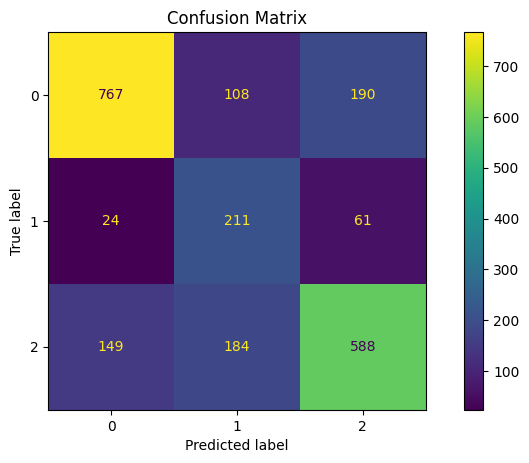

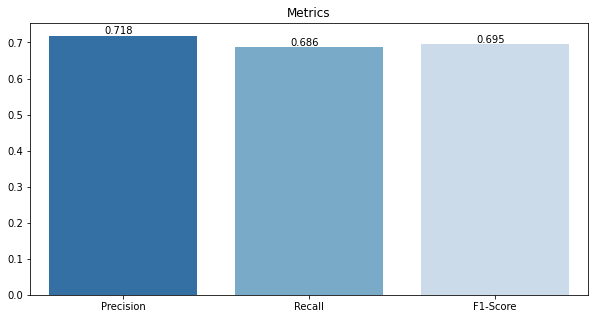

Precision: 0.7180675256978492
Recall: 0.6862401402278703
F1-Score: 0.6952448855967426


In [86]:
# create and train model using the whole training set
classifier = LogisticRegression(multi_class="multinomial", max_iter=1000, class_weight='balanced')
classifier.fit(x_train, y_train)

# validation scores for different metrics
y_predicted_validation = classifier.predict(x_validation)
precision = precision_score(y_validation, y_predicted_validation, average='weighted')
recall = recall_score(y_validation, y_predicted_validation, average='weighted')
f1 = f1_score(y_validation, y_predicted_validation, average='weighted')

# plot confusion matrix
fig, ax = plt.subplots(figsize=(10, 5), dpi=100)
plt.title('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(classifier, x_validation, y_validation, ax=ax)
plt.show()

# plot scores
plt.figure(figsize=(10, 5))
plt.title('Metrics')
sns.barplot(x=['Precision', 'Recall', 'F1-Score'], y=[precision, recall, f1], palette='Blues_r')
for index, value in enumerate([precision, recall, f1]):
    plt.text(index-0.1, value+0.005,str(round(value,3)))
plt.show()
print('Precision: ' + str(precision))
print('Recall: ' + str(recall))
print('F1-Score: ' + str(f1))

## **Learning Curve**

Training Size: 100
Training Size: 1864
Training Size: 3628
Training Size: 5392
Training Size: 7156
Training Size: 8920
Training Size: 10684
Training Size: 12448
Training Size: 14212
Training Size: 15976


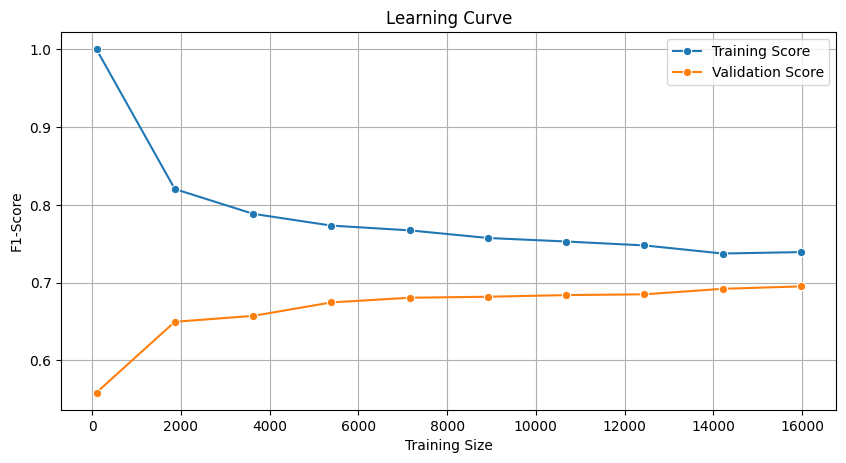

In [87]:
training_sizes = np.linspace(100, x_train.shape[0], 10)
training_sizes = [int(size) for size in training_sizes]
training_scores = []
validation_scores = []

# train the model for 10 different training sizes and save training and validation f1_scores
for training_size in training_sizes:
  print('Training Size: ' + str(training_size))
  classifier.fit(x_train[:training_size, :], y_train[:training_size])
  training_predictions = classifier.predict(x_train[:training_size, :])
  validation_predictions = classifier.predict(x_validation)
  training_scores.append(f1_score(y_train[:training_size], training_predictions, average='weighted'))
  validation_scores.append(f1_score(y_validation, validation_predictions, average='weighted'))

# plot the learning curve
plt.figure(figsize=(10, 5), dpi=100)
plt.title('Learning Curve')
plt.xlabel('Training Size')
plt.ylabel('F1-Score')
sns.lineplot(x=training_sizes, y=training_scores,  marker="o")
sns.lineplot(x=training_sizes, y=validation_scores,  marker="o")
plt.legend(['Training Score', 'Validation Score'])
plt.grid()
plt.show()

## **Predictions**

In [88]:
# gets text and prints predicted sentiment
def predict_sentiment(text):
  text = preprocess(text)
  text_vector = vectorize(vectorizer, [text])
  prediction = classifier.predict(text_vector)
  if prediction[0] == 0:
    print('Neutral Sentiment')
  elif prediction[0] == 1:
    print('Anti-vaccinist')
  elif prediction[0] == 2:
    print('Pro-vaccinist')


# some examples
predict_sentiment("Vaccines kill people")
predict_sentiment("I am in favour of vaccines, I believe they will help fight coronavirus")
predict_sentiment("The society is divided in this whole covid-19 pandemic")
predict_sentiment("I hate anti-vaccinists")
predict_sentiment("Vaccines are fake")
predict_sentiment("I cannot understand why people say vaccines are fake!")
predict_sentiment("Get your children vaccinated people!")

Anti-vaccinist
Pro-vaccinist
Neutral Sentiment
Pro-vaccinist
Anti-vaccinist
Anti-vaccinist
Pro-vaccinist
